In [1]:
!which python

/scratch/ci411/.conda/envs/rap_env/bin/python


In [5]:
import numpy as np
import numpy.ma as ma
import librosa as lr
from librosa import feature
import matplotlib.pyplot as plt
import os

from librosa import display
from IPython.display import Audio

import jams

In [6]:
from librosa import pyin

In [9]:
DATA_PATH = '/scratch/ci411/rap_data/flowBook/AudioExcerpts'

In [10]:
audio_clips = []
for subdir in os.listdir(DATA_PATH):
    if "Chapter" in subdir:
        chapter_path = os.path.join(DATA_PATH, subdir)
        for file in os.listdir(chapter_path):
            if '.wav' in file:
                audio_path = os.path.join(chapter_path, file)
                audio_clips.append(audio_path)

In [11]:
example_audio_path = "./Excerpt.3.15b.wav"

In [ ]:
Audio(example_audio_path)

In [ ]:
y_test, sr_test = lr.load(example_audio_path)
test_length_s = len(y_test)/sr_test

In [9]:
frame_length = 2048
f0_test, _, _  = lr.pyin(y_test, lr.note_to_hz('C2'), lr.note_to_hz('C7'), sr=sr_test, frame_length=frame_length)

In [10]:
times_test = np.linspace(0, test_length_s, len(y_test)//(frame_length//4) + 1) #number of indices by hop length, frame_length//4, scaled by
max(times_test)

21.000045351473922

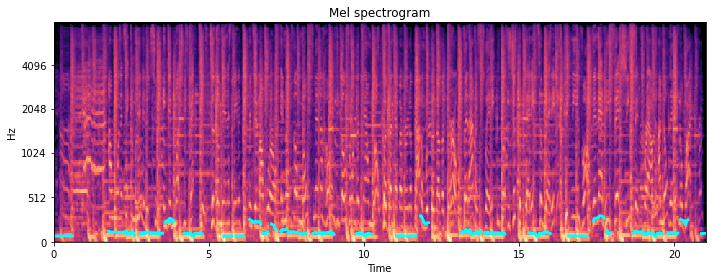

In [11]:
fig = plt.figure(figsize=(10, 4))
ax = plt.gca()
S_test = lr.feature.melspectrogram(y_test)
lr.display.specshow(lr.power_to_db(S_test, ref=np.max),
                    y_axis='mel', fmax=8000, x_axis='time', ax=ax)

ax.plot(times_test, f0_test, label='f0', color='cyan', linewidth=3)
#plt.colorbar(format='%+2.0f dB')
ax.set_title('Mel spectrogram')
plt.tight_layout()

In [12]:
def overplot_pyin(audio_clip, y=None, ax=None):
    if y is None:
        y, sr = lr.load(audio_clip)
    else:
        sr = 22050
    f0, _, _ = lr.pyin(y, lr.note_to_hz('C2'), lr.note_to_hz('C7'), frame_length=2048)
    times = lr.times_like(f0)
    
    S = lr.amplitude_to_db(lr.feature.melspectrogram(y), ref=np.max)
    
    if ax==None:
        fig = plt.figure(figsize=(10, 4))
        ax = plt.gca()
    
    lr.display.specshow(S, y_axis='mel', fmax=8000, x_axis='time', ax=ax)
    ax.plot(times_test, f0_test, label='f0', color='cyan', linewidth=3)
    
    plt.colorbar(plt.cm.ScalarMappable(cmap='magma'), format='%+2.0f dB')
    ax.set_title(audio_clip.split('/')[-1])
    return f0


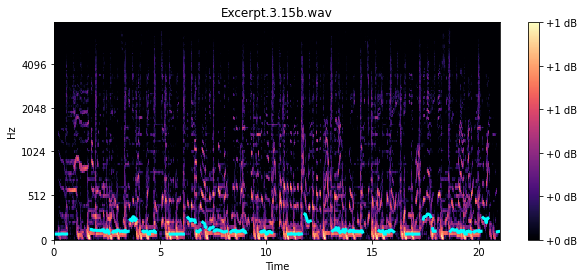

In [13]:
base_pyin_f0 = overplot_pyin(example_audio_path)
Audio(example_audio_path)

In [14]:
from spleeter.separator import Separator
from spleeter.audio.adapter import get_default_audio_adapter

separator = Separator('spleeter:2stems')

audio_loader = get_default_audio_adapter()
sr = 22050
test_audio, _ = audio_loader.load(example_audio_path, sample_rate=sr)


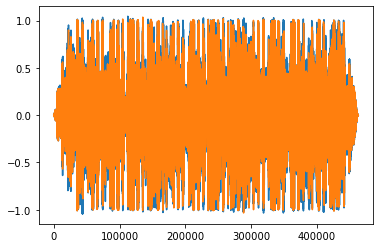

In [15]:
plt.plot(test_audio)

In [16]:
prediction_test = separator.separate(test_audio)

INFO:tensorflow:Apply unet for vocals_spectrogram
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Apply unet for accompaniment_spectrogram


INFO:tensorflow:Restoring parameters from pretrained_models/2stems/model


In [17]:

test_vocals = prediction_test['vocals']

In [18]:
print(test_audio.shape)
print(test_vocals.shape)

(463051, 2)
(463051, 2)


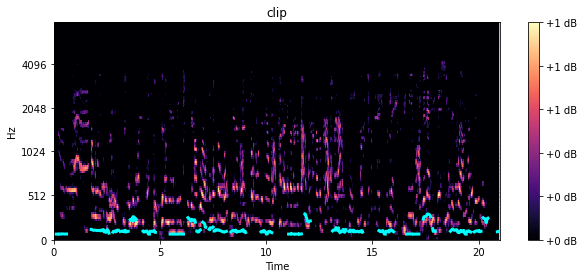

In [19]:
test_vocals = lr.to_mono(prediction_test['vocals'].T)
vox_pyin_f0 = overplot_pyin('clip',y=test_vocals)
Audio(test_vocals, rate=sr)

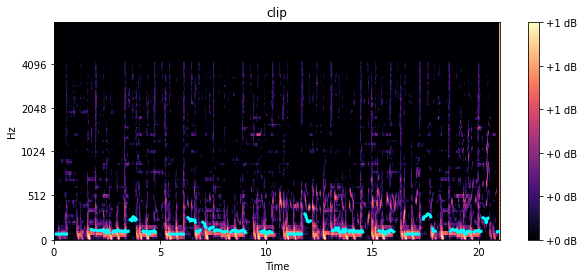

In [20]:
test_accompaniment = lr.to_mono(prediction_test['accompaniment'].T)
accomp_pyin_f0 = overplot_pyin('clip',y=test_accompaniment)
Audio(test_accompaniment, rate=sr)

In [21]:
test_vocals.shape

(463051,)

In [22]:
base_pyin_f0.shape

(905,)

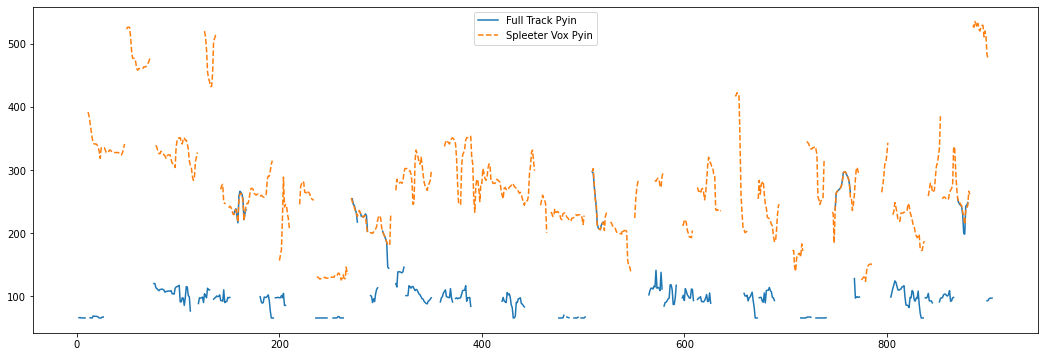

In [23]:
plt.figure(figsize=(18,6))
plt.plot(base_pyin_f0, label="Full Track Pyin")
plt.plot(vox_pyin_f0, linestyle='--', label ="Spleeter Vox Pyin")
plt.legend()

In [24]:
import crepe

In [25]:
base_crepe = crepe.predict(y_test, sr_test)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2101/2101 [==============================] - 61s 29ms/sample


In [26]:
vox_crepe = crepe.predict(test_vocals, sr)

2101/2101 [==============================] - 61s 29ms/sample


In [27]:
thresh=.4
base_crepe_f0 = ma.masked_array(base_crepe[1], mask = base_crepe[2]<thresh)
vox_crepe_f0 = ma.masked_array(vox_crepe[1], mask = vox_crepe[2]<thresh)

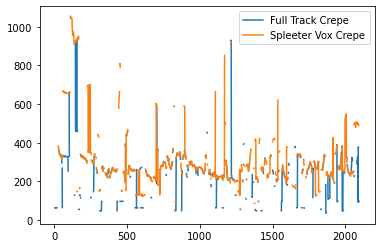

In [28]:
plt.plot(base_crepe_f0, label="Full Track Crepe")
plt.plot(vox_crepe_f0, label="Spleeter Vox Crepe")
plt.legend()

In [29]:
import mir_eval
from mir_eval import melody

In [30]:
print(len(vox_pyin_f0), len(vox_crepe_f0))

905 2101


In [31]:
t_array = melody.constant_hop_timebase(512, 512*(len(vox_pyin_f0)-1))

In [32]:
crepe_freq, crepe_voc = melody.freq_to_voicing(vox_crepe_f0)
crepe_freq, crepe_voc = melody.resample_melody_series(vox_crepe[0], vox_crepe[1], vox_crepe[2], t_array)

In [33]:
pyin_freq, pyin_voc = melody.freq_to_voicing(vox_pyin_f0)

melody.validate_voicing(pyin_voc, crepe_voc)
melody.validate(pyin_voc, melody.hz2cents(pyin_freq), crepe_voc, melody.hz2cents(crepe_freq))

/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/mir_eval/melody.py:183: RuntimeWarning: invalid value encountered in greater
  voicing = (frequencies > 0).astype(float)


In [34]:
melody.voicing_measures(pyin_voc, crepe_voc)

(0.007603826518134416, 0.007562477699231092)

In [35]:
eval_results = melody.evaluate(t_array, melody.hz2cents(pyin_freq), t_array, melody.hz2cents(crepe_freq))
eval_results = dict(eval_results)

/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/mir_eval/melody.py:569: RuntimeWarning: invalid value encountered in less
  correct_frequencies = freq_diff_cents < cent_tolerance
/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/mir_eval/melody.py:637: RuntimeWarning: invalid value encountered in less
  correct_chroma = np.abs(freq_diff_cents - octave) < cent_tolerance
/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/mir_eval/melody.py:697: RuntimeWarning: invalid value encountered in less
  correct_frequencies = freq_diff_cents < cent_tolerance


In [36]:
test_rms = lr.feature.rms(y=test_vocals)

In [37]:
test_rms.shape

(1, 905)

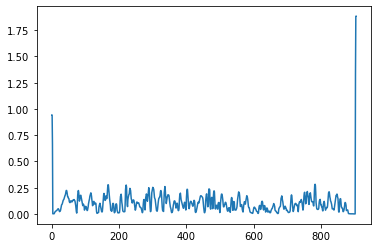

In [38]:
plt.plot(test_rms[0])

In [39]:
eval_results

{'Voicing Recall': 1.0,
 'Voicing False Alarm': 0.9946236559139785,
 'Raw Pitch Accuracy': 0.0,
 'Raw Chroma Accuracy': 0.29902642559109877,
 'Overall Accuracy': 0.0011049723756906078}

In [40]:
import jams

In [41]:
test_jams = jams.JAMS()

In [42]:
test_sandbox = jams.Sandbox()

In [43]:
test_sandbox = eval_results

In [44]:
test_jams.sandbox.append(eval_results)

AttributeError: 'Sandbox' object has no attribute 'append'